In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import datetime

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
crowd_data_2019 = pd.read_parquet('./crowdsourced_failures_2019').reset_index(drop=True)
crowd_data_2018 = pd.read_parquet('./crowdsourced_failures_2018').reset_index(drop=True)
crowd_data = pd.concat([crowd_data_2018, crowd_data_2019]).drop(columns=['location'])
crowd_data = crowd_data[crowd_data['vendor'] != 'livejournal'].copy()
crowd_data = crowd_data[crowd_data['vendor'] != 'foursquare'].copy()
crowd_data = crowd_data[crowd_data['vendor'] != 'typepad'].copy()
crowd_data = crowd_data[crowd_data['vendor'] != 'ning'].copy()
crowd_data = crowd_data[(crowd_data['event_time'].dt.year == 2018) | (crowd_data['event_time'].dt.year == 2019)].copy()

In [3]:
# Total datapoints
crowd_data[crowd_data['monitor'] == 'Down Right Now'].shape

(364603, 4)

In [4]:
# Datapoints dropped due to nan values in status code
crowd_data[crowd_data['monitor'] == 'Down Right Now'].shape[0] - crowd_data[crowd_data['monitor'] == 'Down Right Now'].dropna(subset=['status_code']).shape[0]

970

In [5]:
# Remove nan values and common values between the 2018 and 2019 dataset
downrightnow_data = crowd_data[crowd_data['monitor'] == 'Down Right Now'].copy().dropna(subset=['status_code']).drop_duplicates()

In [6]:
# Events in 2018 vs 2019
(downrightnow_data['event_time'].dt.year == 2018).value_counts()

False    203498
True     159664
Name: event_time, dtype: int64

In [7]:
# Make outlier masks
# Remove all status_code 0.6 data for novemeber 2018
nov2018_mask = (downrightnow_data['status_code'] == 0.6) & (downrightnow_data['event_time'].dt.month == 11) & (downrightnow_data['event_time'].dt.year == 2018)
# Remove all status_code 0.6 data for twitter for december 2018
twitter2018_mask = (downrightnow_data['status_code'] == 0.6) & (downrightnow_data['vendor'] == 'twitter') & (downrightnow_data['event_time'].dt.month == 12) & (downrightnow_data['event_time'].dt.year == 2018)
# Remove all status_code 0.6 data for twitter from january to june 2019
twitter2019_mask = (downrightnow_data['status_code'] == 0.6) & (downrightnow_data['vendor'] == 'twitter') & (downrightnow_data['event_time'].dt.month >= 1) & (downrightnow_data['event_time'].dt.month <= 6) & (downrightnow_data['event_time'].dt.year == 2019)

all_outliers_mask = nov2018_mask | twitter2018_mask | twitter2019_mask

In [8]:
# Number of datapoints removed as outliers
all_outliers_mask.value_counts()

False    314122
True      49040
dtype: int64

In [9]:
# Checking for outliers
drn_copy = downrightnow_data.copy()
drn_copy['year'] = drn_copy.event_time.dt.year
drn_copy['month'] = drn_copy.event_time.dt.month
drn_month_event_count = drn_copy.groupby(['year', 'month']).count().rename(columns={
    'event_time': 'count'
}).reset_index()
drn_month_event_count[((drn_month_event_count['year'] == 2018) & (drn_month_event_count['month'] < 11))
                     | ((drn_month_event_count['year'] == 2019) & (drn_month_event_count['month'] > 6))].median()

year            2018.0
month              7.5
count          11182.0
status_code    11182.0
vendor         11182.0
monitor        11182.0
dtype: float64

In [10]:
# Checking for outliers
drn_month_event_count[((drn_month_event_count['year'] == 2018) & (drn_month_event_count['month'] >= 11))
                     | ((drn_month_event_count['year'] == 2019) & (drn_month_event_count['month'] <= 6))].mean()

year            2018.75
month              5.50
count          22984.50
status_code    22984.50
vendor         22984.50
monitor        22984.50
dtype: float64

In [11]:
# Checking for outliers
drn_month_status_count = drn_copy.groupby(['year', 'month', 'status_code']).count().rename(columns={
    'event_time': 'count'
}).reset_index()
drn_month_status_count

,year,month,status_code,count,vendor,monitor
0,2018,1,0.4,226,226,226
1,2018,1,0.6,918,918,918
2,2018,1,0.8,148,148,148
3,2018,1,1.0,10672,10672,10672
4,2018,2,0.4,225,225,225
...,...,...,...,...,...,...
94,2019,11,1.0,10533,10533,10533
95,2019,12,0.4,99,99,99
96,2019,12,0.6,534,534,534
97,2019,12,0.8,89,89,89


In [12]:
# Checking for outliers
drn_copy[((downrightnow_data['status_code'] == 0.6) & (downrightnow_data['event_time'].dt.month < 11) & (downrightnow_data['event_time'].dt.year == 2018))].groupby('month').count().median()

event_time     548.5
status_code    548.5
vendor         548.5
monitor        548.5
year           548.5
dtype: float64

In [13]:
# Checking for outliers
drn_copy[((downrightnow_data['status_code'] == 0.6) & (downrightnow_data['vendor'] == 'twitter') & (downrightnow_data['event_time'].dt.month < 11) & (downrightnow_data['event_time'].dt.year == 2018))
        | ((downrightnow_data['status_code'] == 0.6) & (downrightnow_data['vendor'] == 'twitter') & (downrightnow_data['event_time'].dt.month > 6) & (downrightnow_data['event_time'].dt.year == 2019))].groupby('month').count().median()

event_time     91.5
status_code    91.5
vendor         91.5
monitor        91.5
year           91.5
dtype: float64

In [14]:
# Checking for outliers
drn_copy[((downrightnow_data['status_code'] == 0.6) & (downrightnow_data['vendor'] == 'twitter') & (downrightnow_data['event_time'].dt.month >= 11) & (downrightnow_data['event_time'].dt.year == 2018))
        | ((downrightnow_data['status_code'] == 0.6) & (downrightnow_data['vendor'] == 'twitter') & (downrightnow_data['event_time'].dt.month <= 6) & (downrightnow_data['event_time'].dt.year == 2019))].groupby('month').count().median()

event_time     6294.0
status_code    6294.0
vendor         6294.0
monitor        6294.0
year           6294.0
dtype: float64

In [15]:
# Drop outliers
cleaned_data = downrightnow_data[~all_outliers_mask].copy().reset_index(drop=True)
# Replace floats with integers in status
cleaned_data['status_code'] = pd.Categorical(cleaned_data['status_code'].replace([1, 0.8, 0.6, 0.4, 0], [1, 2, 3, 4, 5]).astype(np.int64))

In [16]:
def compute_intervals(unsorted_df):
    # Input needs to be sorted
    df = unsorted_df.sort_values('event_time').reset_index(drop=True)
    list_of_events = []
    prev_status = 1
    prev_status_start_time = None
    for _, row in df.iterrows():
        new_status = row['status_code']
        new_event_time = row['event_time']
        if new_status != prev_status:
            if prev_status != 1:
                list_of_events.append({
                    'event_start_time': prev_status_start_time,
                    'event_end_time': new_event_time,
                    'status_code': prev_status
                })
            
            prev_status = new_status
            prev_status_start_time = new_event_time
            
    return pd.DataFrame(list_of_events)

In [17]:
# Compute up and down intervals from discrete events
intervals_df_list = []
for vendor in cleaned_data['vendor'].unique():
    sorted_partial_df = cleaned_data.loc[cleaned_data['vendor'] == vendor, :].sort_values('event_time')
    intervals_partial_df = compute_intervals(sorted_partial_df)
    intervals_partial_df['status_code'] = pd.Categorical(intervals_partial_df['status_code'], [5, 4, 3, 2], ordered=True)
    intervals_partial_df['vendor'] = vendor
    intervals_df_list.append(intervals_partial_df)

all_intervals_df = pd.concat(intervals_df_list).sort_values('event_start_time').reset_index(drop=True)

In [18]:
# Number of intervals in 2018 and 2019
(all_intervals_df['event_start_time'].dt.year == 2018).value_counts()

True     6916
False    6618
Name: event_start_time, dtype: int64

In [19]:
grid_array = np.full((365, 24), 0)
for intervals_df in intervals_df_list:
    for _, row in intervals_df[intervals_df['event_start_time'].dt.year == 2018].iterrows():
        start_day_of_year = row['event_start_time'].timetuple().tm_yday
        start_hour_of_day = row['event_start_time'].hour
        end_day_of_year = row['event_end_time'].timetuple().tm_yday
        end_hour_of_day = row['event_end_time'].hour
        for day_of_year in range(start_day_of_year, end_day_of_year+1):
            if start_day_of_year == end_day_of_year: # less than a day
                for hour_of_day in range(start_hour_of_day, end_hour_of_day):
                    grid_array[day_of_year-1, hour_of_day-1] = 1
            elif day_of_year == start_day_of_year: # first day
                for hour_of_day in range(start_hour_of_day, 25):
                    grid_array[day_of_year-1, hour_of_day-1] = 1
            elif day_of_year == end_day_of_year: # last day
                for hour_of_day in range(0, end_hour_of_day):
                    grid_array[day_of_year-1, hour_of_day-1] = 1
            else: # middle day
                for hour_of_day in range(1, 25):
                    grid_array[day_of_year-1, hour_of_day-1] = 1

grid_df = pd.DataFrame({
    'day_of_year': np.repeat(np.arange(1, 365+1), 24),
    'hour_of_day': np.tile(np.arange(1, 24+1), 365),
    'status': pd.Categorical(grid_array.flatten(), [0,1], ordered=True)
})

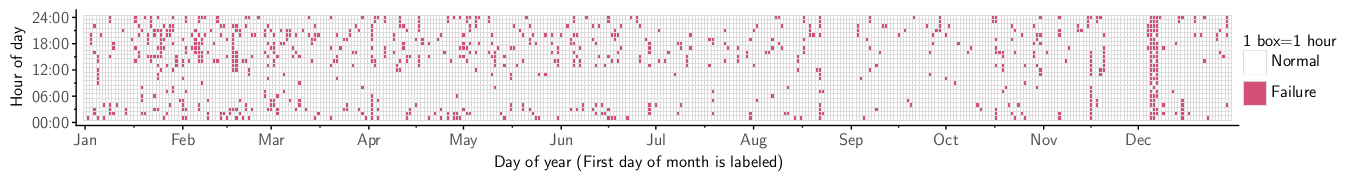

In [20]:
# Always! plot stuff to verify the data looks reasonable
plt = ggplot(grid_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_tile(mapping=aes(x='day_of_year', y='hour_of_day', fill='status'), color='gainsboro', size=0.01) +\
    scale_fill_manual(values=['white', '#d45079'], labels=['Normal', 'Failure']) +\
    scale_x_continuous(limits=(0, 365), expand=(0.005, 0.005),
                       breaks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335],
                       labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) +\
    scale_y_continuous(breaks=[0, 6, 12, 18, 24],
                       labels=['00:00', '06:00', '12:00', '18:00', '24:00']) +\
    theme(figure_size=(15, 1.5)) +\
    guides(fill=guide_legend(title='1 box=1 hour')) +\
    ylab('Hour of day') +\
    xlab('Day of year (First day of month is labeled)') +\
    theme(legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          text=element_text(size=12))

plt.draw()

In [21]:
def proper_vendor_names(series):
    return series.str.capitalize().replace(['Yahoomail', 'Youtube', 'Linkedin', 'Paypal'], ['YahooMail', 'YouTube', 'LinkedIn', 'PayPal'])

all_intervals_df['status_name'] = pd.Categorical(all_intervals_df['status_code'].replace([2, 3, 4, 5], ['Maybe Down', 'Possibly Down', 'Likely Down', 'Surely Down']),
                                                ['Surely Down', 'Likely Down', 'Possibly Down', 'Maybe Down'], ordered=True)
all_intervals_df['vendor_proper'] = proper_vendor_names(all_intervals_df['vendor'])
descending_vendor_order = all_intervals_df.groupby('vendor_proper').count().reset_index().sort_values('status_code', ascending=False)['vendor_proper']
all_intervals_df['vendor_cat'] = pd.Categorical(all_intervals_df['vendor_proper'],
                                                descending_vendor_order, ordered=True)
all_intervals_df['year'] = all_intervals_df['event_start_time'].dt.year

In [22]:
all_intervals_df.groupby('status_name').count()

,event_start_time,event_end_time,status_code,vendor,vendor_proper,vendor_cat,year
status_name,,,,,,,
Surely Down,12,12,12,12,12,12,12
Likely Down,2135,2135,2135,2135,2135,2135,2135
Possibly Down,9833,9833,9833,9833,9833,9833,9833
Maybe Down,1554,1554,1554,1554,1554,1554,1554


In [23]:
failures_by_vendor_and_cat = all_intervals_df.groupby(['vendor', 'status_name']).count().reset_index().dropna().rename(columns={
    'event_start_time': 'count'
})[['vendor', 'status_name', 'count']]
failures_by_vendor_type_proportion_list = []
for vendor in failures_by_vendor_and_cat['vendor'].unique():
    partial_df = failures_by_vendor_and_cat[failures_by_vendor_and_cat['vendor'] == vendor]
    total_failures_by_vendor = partial_df['count'].sum()
    partial_df['prop'] = partial_df['count'] / total_failures_by_vendor
    failures_by_vendor_type_proportion_list.append(partial_df)

pd.concat(failures_by_vendor_type_proportion_list).sort_values('prop', ascending=False)

<ipython-input-23-1cf0ea125627>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_df['prop'] = partial_df['count'] / total_failures_by_vendor


,vendor,status_name,count,prop
26,paypal,Possibly Down,107.0,0.856000
46,youtube,Possibly Down,1476.0,0.823201
30,skype,Possibly Down,217.0,0.818868
22,netflix,Possibly Down,1020.0,0.808882
42,yahoomail,Possibly Down,3012.0,0.778496
2,blogger,Possibly Down,194.0,0.754864
10,gmail,Possibly Down,565.0,0.730918
18,linkedin,Possibly Down,171.0,0.670588
38,twitter,Possibly Down,951.0,0.664570
14,hotmail,Possibly Down,566.0,0.621295


/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 4 in image.
  warn("Saving {0} x {1} {2} image.".format(
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/severity_bar.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


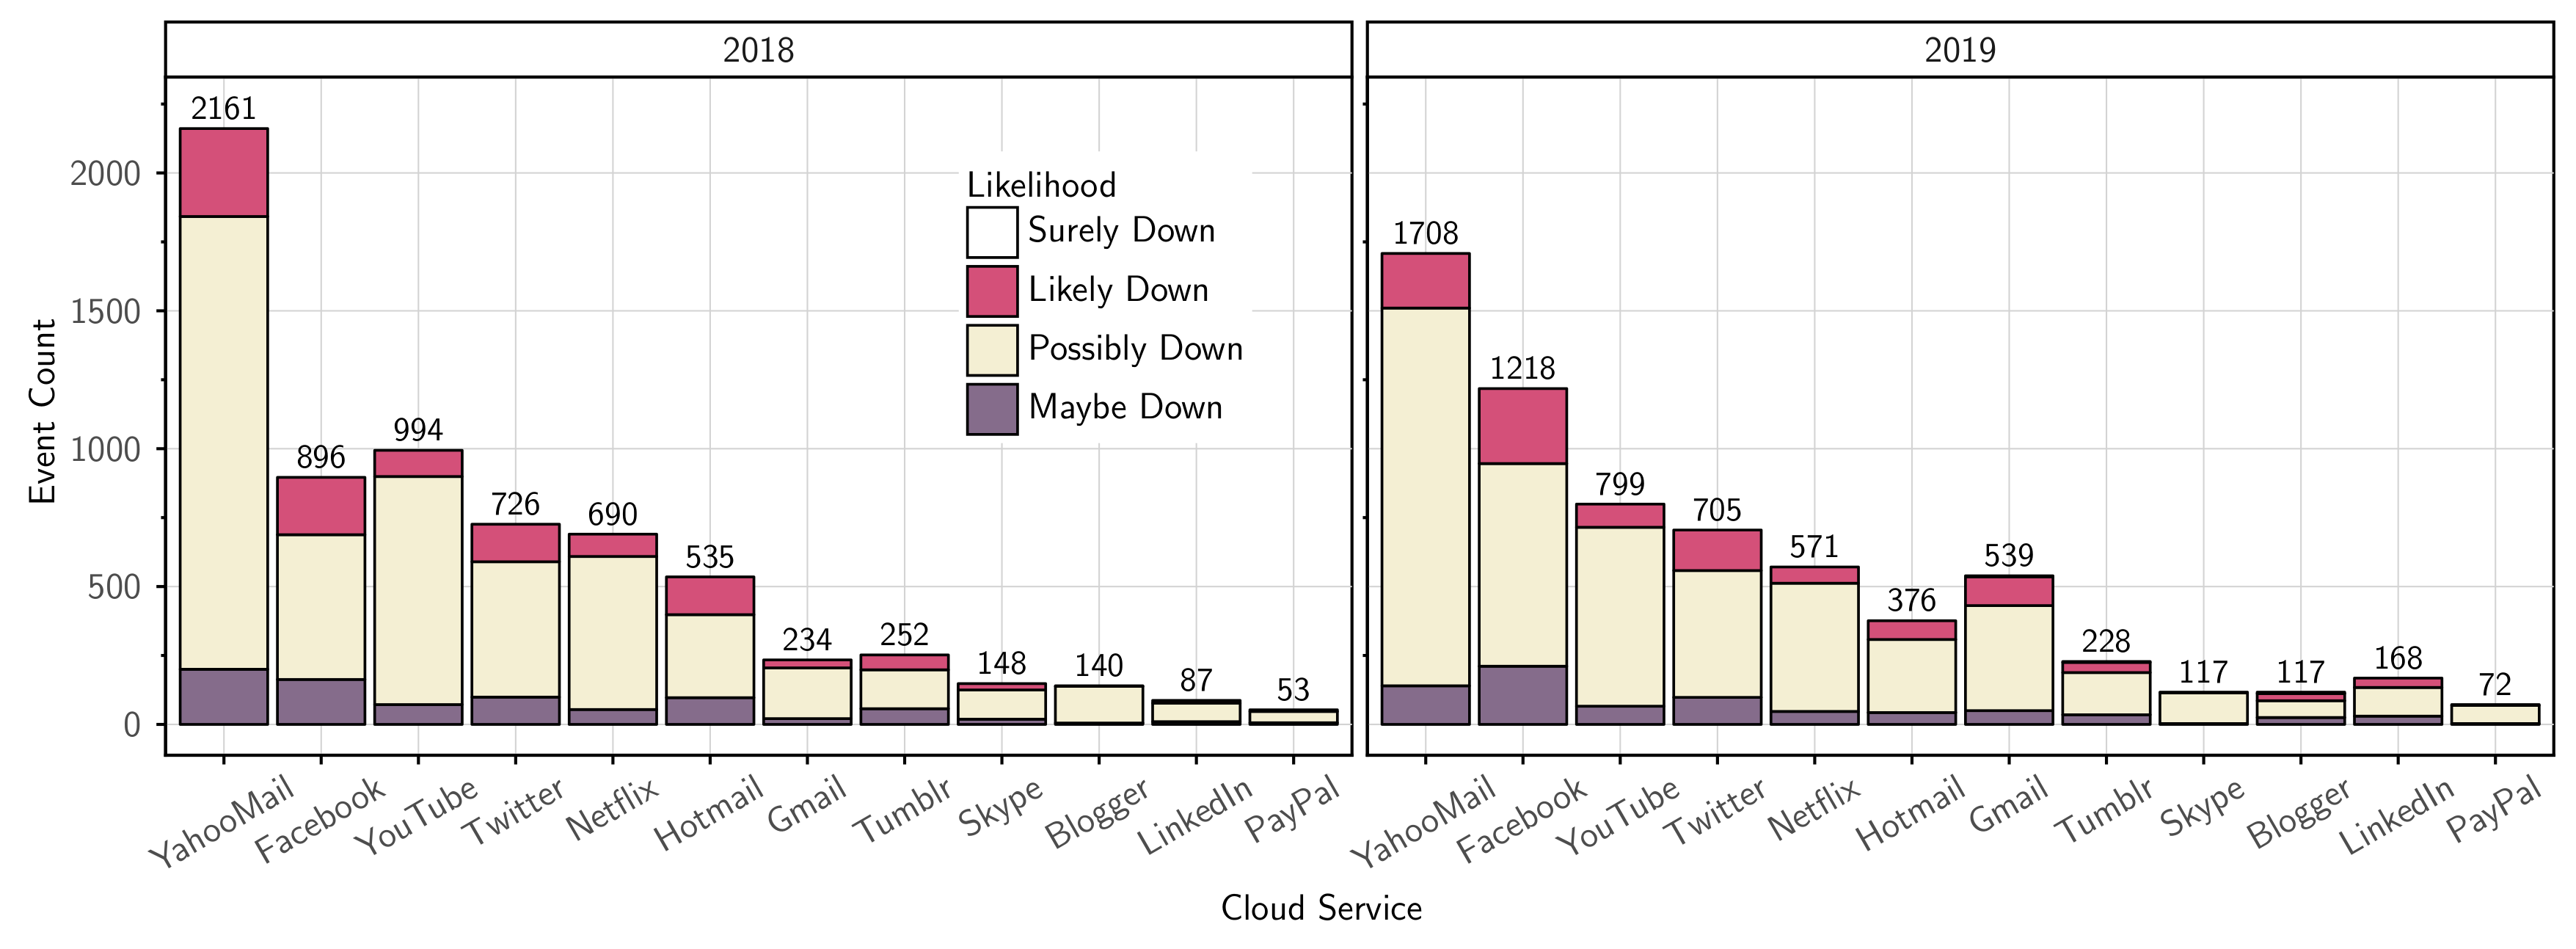

In [24]:
severity_counted_df = all_intervals_df.groupby(['year', 'vendor_cat']).count().reset_index()[['year', 'vendor_cat', 'event_start_time']].rename(columns={
    'event_start_time': 'count'
})

# All right! first step is segmented bar graph per service
plt = ggplot(all_intervals_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_bar(aes(x='vendor_cat', fill='status_name'), color='black') +\
    geom_text(aes(x='vendor_cat', y='count + 75', label='count'), data=severity_counted_df) +\
    facet_wrap(facets=['year'], ncol=2) +\
    xlab('Cloud Service') +\
    ylab('Event Count') +\
    scale_fill_manual(['white', '#d45079', '#f4efd3', '#856c8b']) +\
    guides(fill=guide_legend(title='Likelihood')) +\
    theme(figure_size=(14, 4), legend_position=(0.43, 0.63), dpi=300,
          legend_key=element_rect(alpha=0),
          axis_text_y=element_text(margin={'r': 5}),
          axis_text_x=element_text(rotation=30),
          panel_grid_major_x=element_line(size=0.5, color='#D3D3D3'),
          panel_grid_major_y=element_line(size=0.5, color='#D3D3D3'),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          text=element_text(size=12),
          panel_border=element_rect(size=1))

plt.save('figures/severity_bar.pdf')
plt.draw()

In [25]:
vendor_status_pairs = all_intervals_df.groupby(['vendor_cat', 'status_name']).count().reset_index().rename(columns={'event_start_time':'count'}).sort_values('count')[['vendor_cat', 'status_name', 'count']]
vendor_high_cert_dicts = []
for vendor in vendor_status_pairs['vendor_cat'].unique():
    partial_df = vendor_status_pairs[vendor_status_pairs['vendor_cat'] == vendor].copy()
    vendor_status_datapoint = {
        'high_cert_prop': partial_df.loc[(partial_df['status_name'] == 'Surely Down') | (partial_df['status_name'] == 'Likely Down'), 'count'].sum() / partial_df['count'].sum(),
        'vendor': vendor
    }
    vendor_high_cert_dicts.append(vendor_status_datapoint)

pd.DataFrame(vendor_high_cert_dicts).sort_values('high_cert_prop')

,high_cert_prop,vendor
3,0.072000,PayPal
4,0.098113,Skype
7,0.099833,YouTube
6,0.111023,Netflix
2,0.128405,Blogger
10,0.133626,YahooMail
5,0.172549,LinkedIn
1,0.177232,Gmail
0,0.195833,Tumblr
9,0.197764,Twitter


In [26]:
vendor_year_status_pairs = all_intervals_df.groupby(['vendor_cat', 'year', 'status_name']).count().reset_index().rename(columns={'event_start_time':'count'}).sort_values('count')[['vendor_cat', 'year', 'status_name', 'count']]
vendor_year_status_dfs = []
for year in vendor_year_status_pairs['year'].unique():
    for vendor in vendor_year_status_pairs['vendor_cat'].unique():
        partial_df = vendor_year_status_pairs[(vendor_year_status_pairs['year'] == year) & (vendor_year_status_pairs['vendor_cat'] == vendor)].copy()
        partial_df['prop'] = partial_df['count'] / partial_df['count'].sum()
        vendor_year_status_dfs.append(partial_df)
        
pd.concat(vendor_year_status_dfs).sort_values(['vendor_cat', 'status_name', 'year']).reset_index(drop=True)

,vendor_cat,year,status_name,count,prop
0,YahooMail,2018,Surely Down,NaN,NaN
1,YahooMail,2019,Surely Down,NaN,NaN
2,YahooMail,2018,Likely Down,319.0,0.147617
3,YahooMail,2019,Likely Down,198.0,0.115925
4,YahooMail,2018,Possibly Down,1642.0,0.759833
...,...,...,...,...,...
91,PayPal,2019,Likely Down,3.0,0.041667
92,PayPal,2018,Possibly Down,41.0,0.773585
93,PayPal,2019,Possibly Down,66.0,0.916667
94,PayPal,2018,Maybe Down,6.0,0.113208


In [27]:
all_intervals_df.groupby(['year', 'status_name']).count()

event_start_time  event_end_time  status_code  vendor  \
year status_name                                                            
2018 Surely Down                 NaN             NaN          NaN     NaN   
     Likely Down              1100.0          1100.0       1100.0  1100.0   
     Possibly Down            5013.0          5013.0       5013.0  5013.0   
     Maybe Down                803.0           803.0        803.0   803.0   
2019 Surely Down                12.0            12.0         12.0    12.0   
     Likely Down              1035.0          1035.0       1035.0  1035.0   
     Possibly Down            4820.0          4820.0       4820.0  4820.0   
     Maybe Down                751.0           751.0        751.0   751.0   

                    vendor_proper  vendor_cat  
year status_name                               
2018 Surely Down              NaN         NaN  
     Likely Down           1100.0      1100.0  
     Possibly Down         5013.0      5013.0  
     Maybe Down             803.0       803.0  
2019 Surely Down             12.0        12.0  
     Likely Down           1035.0      1035.0  
     Possibly Down         4820.0      4820.0  
     Maybe Down             751.0       751.0

In [28]:
# Fraction of high certainty events
pd.DataFrame(vendor_high_cert_dicts).sort_values('high_cert_prop')['high_cert_prop'].median()

0.1530876398116755

In [29]:
# Next, CDF of duration. Multiplot again, by service. Two years in the same plot
# Compute duration first, and convert it to seconds
temp_series = (all_intervals_df['event_end_time'].values.astype(np.int64) - all_intervals_df['event_start_time'].values.astype(np.int64)) // np.int64(1e9)
all_intervals_df['duration'] = temp_series

In [30]:
# Events longer than 5 minutes
all_intervals_df.loc[all_intervals_df['duration'] > 300, 'duration']

6        2100
27       2160
33       3600
45        600
47       2400
         ... 
13490    2460
13507    1800
13523    1800
13528    3000
13531     900
Name: duration, Length: 1534, dtype: int64

In [31]:
# Events with zero duration
(all_intervals_df['duration'] == 0).value_counts()

False    8486
True     5048
Name: duration, dtype: int64

In [32]:
all_intervals_df.loc[all_intervals_df['duration'] == 0, :]

,event_start_time,event_end_time,status_code,vendor,status_name,vendor_proper,vendor_cat,year,duration
0,2018-01-01 18:50:00,2018-01-01 18:50:00,3,youtube,Possibly Down,YouTube,YouTube,2018,0
2,2018-01-01 18:56:00,2018-01-01 18:56:00,3,youtube,Possibly Down,YouTube,YouTube,2018,0
3,2018-01-02 01:20:00,2018-01-02 01:20:00,3,netflix,Possibly Down,Netflix,Netflix,2018,0
4,2018-01-02 01:21:00,2018-01-02 01:21:00,3,netflix,Possibly Down,Netflix,Netflix,2018,0
5,2018-01-02 01:25:00,2018-01-02 01:25:00,3,netflix,Possibly Down,Netflix,Netflix,2018,0
...,...,...,...,...,...,...,...,...,...
13519,2019-12-27 19:35:00,2019-12-27 19:35:00,3,blogger,Possibly Down,Blogger,Blogger,2019,0
13522,2019-12-28 21:30:00,2019-12-28 21:30:00,3,youtube,Possibly Down,YouTube,YouTube,2019,0
13524,2019-12-28 21:31:00,2019-12-28 21:31:00,3,youtube,Possibly Down,YouTube,YouTube,2019,0
13527,2019-12-29 19:10:00,2019-12-29 19:10:00,3,yahoomail,Possibly Down,YahooMail,YahooMail,2019,0


In [33]:
all_intervals_df.groupby('year')['duration'].sum()

year
2018    2044920
2019    1882740
Name: duration, dtype: int64

In [34]:
all_intervals_df.groupby('status_name')['duration'].sum()

status_name
Surely Down         1380
Likely Down       689880
Possibly Down    2804400
Maybe Down        432000
Name: duration, dtype: int64

In [35]:
all_intervals_df.sort_values('duration', ascending=False)

,event_start_time,event_end_time,status_code,vendor,status_name,vendor_proper,vendor_cat,year,duration
7947,2019-03-13 16:02:00,2019-03-14 03:05:00,4,facebook,Likely Down,Facebook,Facebook,2019,39780
10389,2019-07-03 13:56:00,2019-07-03 22:20:00,4,facebook,Likely Down,Facebook,Facebook,2019,30240
6304,2018-11-15 22:42:00,2018-11-16 05:10:00,4,hotmail,Likely Down,Hotmail,Hotmail,2018,23280
1595,2018-02-17 14:01:00,2018-02-17 20:10:00,4,yahoomail,Likely Down,YahooMail,YahooMail,2018,22140
6424,2018-11-20 12:51:00,2018-11-20 18:15:00,4,facebook,Likely Down,Facebook,Facebook,2018,19440
...,...,...,...,...,...,...,...,...,...
6614,2018-12-07 00:56:00,2018-12-07 00:56:00,3,youtube,Possibly Down,YouTube,YouTube,2018,0
6605,2018-12-06 21:15:00,2018-12-06 21:15:00,3,blogger,Possibly Down,Blogger,Blogger,2018,0
6604,2018-12-06 21:10:00,2018-12-06 21:10:00,3,blogger,Possibly Down,Blogger,Blogger,2018,0
6603,2018-12-06 21:00:00,2018-12-06 21:00:00,3,youtube,Possibly Down,YouTube,YouTube,2018,0


In [36]:
# Now, compute duration CDF per year per vendor
grouped_duration = all_intervals_df.groupby(['year', 'vendor', 'duration']).count().reset_index()[['year', 'vendor', 'duration', 'event_start_time']].rename(columns={
    'event_start_time': 'count'
})
duration_cdf_list = []
for year in grouped_duration['year'].unique():
    for vendor in grouped_duration['vendor'].unique():
        partial_df = grouped_duration.loc[(grouped_duration['year'] == year) & (grouped_duration['vendor'] == vendor), :].copy()
        partial_df['pdf'] = partial_df['count'] / partial_df['count'].sum()
        sorted_partial_duration = partial_df.sort_values('duration')
        sorted_partial_duration['cdf'] = sorted_partial_duration['pdf'].cumsum()
        duration_cdf_list.append(sorted_partial_duration)
duration_cdf = pd.concat(duration_cdf_list)
duration_cdf['vendor_cat'] = pd.Categorical(proper_vendor_names(duration_cdf['vendor']), descending_vendor_order, ordered=True)
duration_cdf['year_cat'] = duration_cdf['year'].replace([2018, 2019], ['2018', '2019'])

/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 4 in image.
  warn("Saving {0} x {1} {2} image.".format(
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/duration_cdf.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 5 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs

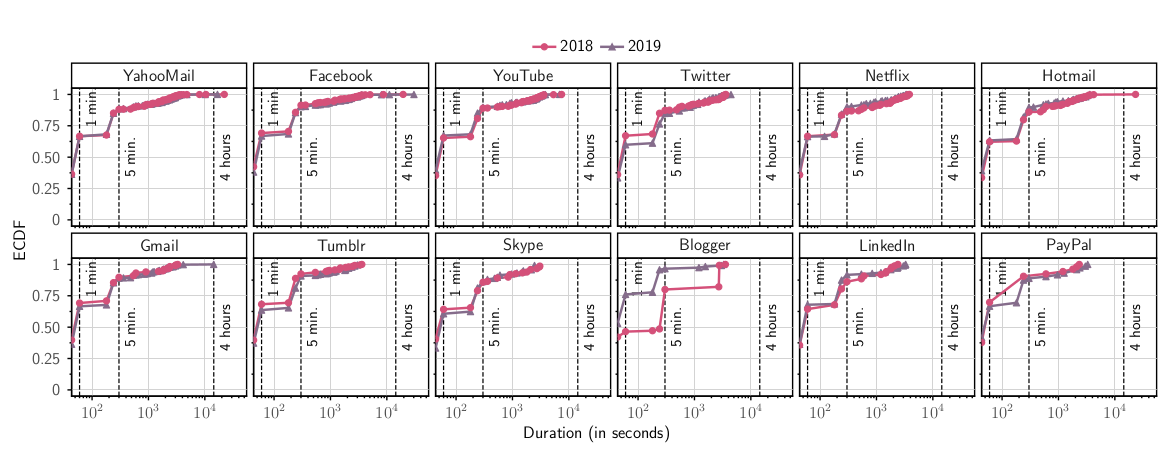

In [37]:
# duration CDF
duration_identification_data = pd.DataFrame({
    'sec': [60, 5*60, 4*60*60],
    'y': [0.9,0.5,0.5],
    'label': ['1 min.', '5 min.', '4 hours']
})

plt = ggplot(duration_cdf) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_vline(aes(xintercept='sec'), data=duration_identification_data, linetype='--') +\
    geom_text(aes(x='sec', y='y', label='label'), data=duration_identification_data, angle=90, ha='left', nudge_x=0.1) +\
    geom_line(aes(x='duration', y='cdf', group='year_cat', color='year_cat'), size=1) +\
    geom_point(aes(x='duration', y='cdf', group='year_cat', color='year_cat', fill='year_cat', shape='year_cat'), size=2) +\
    facet_wrap(facets=['vendor_cat'], ncol=6) +\
    scale_x_log10(labels=lambda l: list(map(lambda x: '$10^{}$'.format(int(np.log10(x))), l))) +\
    scale_y_continuous(limits=[0, 1]) +\
    xlab('Duration (in seconds)') +\
    ylab('ECDF') +\
    scale_color_manual(['#d45079', '#856c8b']) +\
    scale_fill_manual(['#d45079', '#856c8b']) +\
    scale_shape_manual(['o', '^',]) +\
    guides(fill=guide_legend(title=''), shape=guide_legend(title=''), color=guide_legend(title='')) +\
    theme(figure_size=(14, 4),
          legend_position='top',
          legend_key=element_rect(alpha=0),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_major_x=element_line(size=0.5, color='#D3D3D3'),
          panel_grid_major_y=element_line(size=0.5, color='#D3D3D3'),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          text=element_text(size=12),
          panel_border=element_rect(size=1))

plt.save('figures/duration_cdf.pdf')
plt.draw()

In [38]:
# Oof! CDF of interarrival
interarrival_cdf_list = []
for year in all_intervals_df['year'].unique():
    for vendor in all_intervals_df['vendor'].unique():
        partial_df = all_intervals_df.loc[(all_intervals_df['year'] == year) & (all_intervals_df['vendor'] == vendor), :].copy()
        
        sorted_partial_df = partial_df.sort_values('event_start_time').reset_index(drop=True)
        sorted_partial_df['ia'] = (sorted_partial_df['event_start_time'].values.astype(np.int64) - np.roll(sorted_partial_df['event_start_time'].values.astype(np.int64), 1)) // np.int64(1e9)
        sorted_partial_df = sorted_partial_df.loc[1:, :]
        
        grouped_partial_df = sorted_partial_df[sorted_partial_df['ia'] >= 0].groupby('ia').count().reset_index()[['ia', 'event_start_time']].rename(columns={
            'event_start_time': 'count'
        }).sort_values('ia').reset_index(drop=True)
        grouped_partial_df['pdf'] = grouped_partial_df['count'] / grouped_partial_df['count'].sum()
        grouped_partial_df['cdf'] = grouped_partial_df['pdf'].cumsum()

        grouped_partial_df['vendor'] = vendor
        grouped_partial_df['year'] = year
        
        interarrival_cdf_list.append(grouped_partial_df)

interarrival_cdf = pd.concat(interarrival_cdf_list)
interarrival_cdf['vendor_cat'] = pd.Categorical(proper_vendor_names(interarrival_cdf['vendor']), descending_vendor_order, ordered=True)
interarrival_cdf['year_cat'] = interarrival_cdf['year'].replace([2018, 2019], ['2018', '2019'])

In [39]:
interarrival_cdf.sort_values('ia', ascending=False)

,ia,count,pdf,cdf,vendor,year,vendor_cat,year_cat
11,27039480,1,0.007194,1.000000,blogger,2018,Blogger,2018
13,7093740,1,0.019231,1.000000,paypal,2018,PayPal,2018
38,6571440,1,0.006803,1.000000,skype,2018,Skype,2018
37,6465900,1,0.006803,0.993197,skype,2018,Skype,2018
29,6389280,1,0.011628,1.000000,linkedin,2018,LinkedIn,2018
...,...,...,...,...,...,...,...,...
0,0,30,0.179641,0.179641,linkedin,2019,LinkedIn,2019
0,0,2,0.017241,0.017241,skype,2019,Skype,2019
0,0,68,0.096591,0.096591,twitter,2019,Twitter,2019
0,0,237,0.194741,0.194741,facebook,2019,Facebook,2019


/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 4 in image.
  warn("Saving {0} x {1} {2} image.".format(
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/interarrival_cdf.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


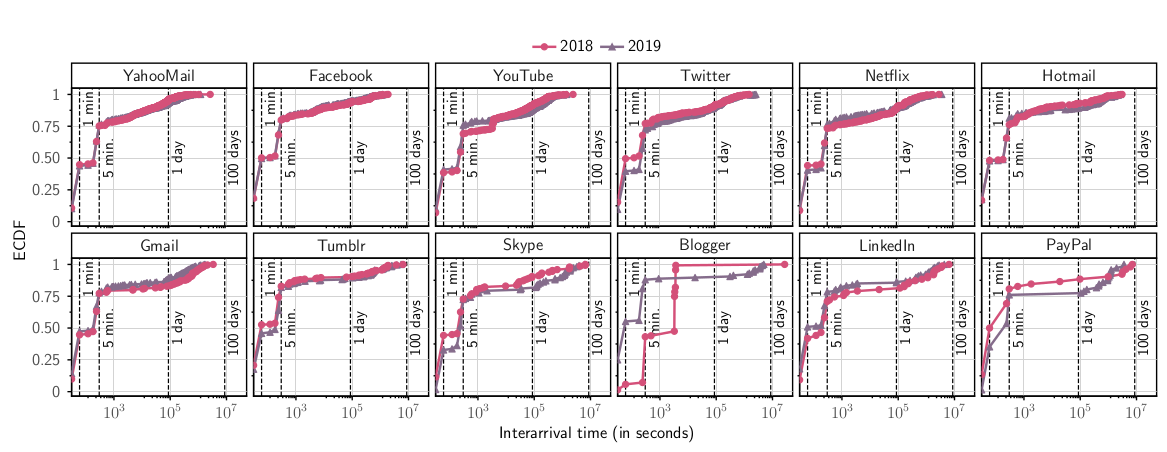

In [40]:
# interarrival CDF
interarrival_identification_data = pd.DataFrame({
    'sec': [60, 5*60, 24*60*60, 100*24*60*60],
    'y': [0.9,0.5,0.5, 0.5],
    'label': ['1 min.', '5 min.', '1 day', '100 days']
})

plt = ggplot(interarrival_cdf) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_vline(aes(xintercept='sec'), data=interarrival_identification_data, linetype='--') +\
    geom_text(aes(x='sec', y='y', label='label'), data=interarrival_identification_data, angle=90, ha='left', nudge_x=0.1) +\
    geom_line(aes(x='ia', y='cdf', group='year_cat', color='year_cat'), size=1) +\
    geom_point(aes(x='ia', y='cdf', group='year_cat', color='year_cat', fill='year_cat', shape='year_cat'), size=2) +\
    facet_wrap(facets=['vendor_cat'], ncol=6) +\
    scale_x_log10(labels=lambda l: list(map(lambda x: '$10^{}$'.format(int(np.log10(x))), l))) +\
    xlab('Interarrival time (in seconds)') +\
    ylab('ECDF') +\
    scale_color_manual(['#d45079', '#856c8b']) +\
    scale_fill_manual(['#d45079', '#856c8b']) +\
    scale_shape_manual(['o', '^',]) +\
    guides(fill=guide_legend(title=''), shape=guide_legend(title=''), color=guide_legend(title='')) +\
    theme(figure_size=(14, 4),
          legend_position='top',
          legend_key=element_rect(alpha=0),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_major_x=element_line(size=0.5, color='#D3D3D3'),
          panel_grid_major_y=element_line(size=0.5, color='#D3D3D3'),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          text=element_text(size=12),
          panel_border=element_rect(size=1))

plt.save('figures/interarrival_cdf.pdf')
plt.draw()

In [41]:
# Time for some sweet sweet weekly trends

weekly_trend_df_list = []
for year in all_intervals_df['year'].unique():
    for vendor in all_intervals_df['vendor'].unique():
        partial_df = all_intervals_df.loc[(all_intervals_df['year'] == year) & (all_intervals_df['vendor'] == vendor), :].copy()
        partial_df['hour_of_week'] = partial_df['event_start_time'].dt.dayofweek * 24 + (partial_df['event_start_time'].dt.hour + 1)
        
        partial_grouped_df = partial_df.groupby('hour_of_week')['event_start_time'].count().reset_index().rename(columns={'event_start_time': 'count'})
        partial_grouped_df['prop'] = partial_grouped_df['count'] / partial_grouped_df['count'].max()
        partial_grouped_df['vendor'] = vendor
        partial_grouped_df['year'] = year
        weekly_trend_df_list.append(partial_grouped_df)

weekly_trend_df = pd.concat(weekly_trend_df_list)
weekly_trend_df['vendor_cat'] = pd.Categorical(proper_vendor_names(weekly_trend_df['vendor']), descending_vendor_order, ordered=True)
weekly_trend_df['year_cat'] = weekly_trend_df['year'].replace([2018, 2019], ['2018', '2019'])

In [42]:
# Failures on weekends vs weekdays
(all_intervals_df['event_start_time'].dt.dayofweek > 4).value_counts() # weekend

False    11278
True      2256
Name: event_start_time, dtype: int64

/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
  warn("Saving {0} x {1} {2} image.".format(
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/weekly_trend.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


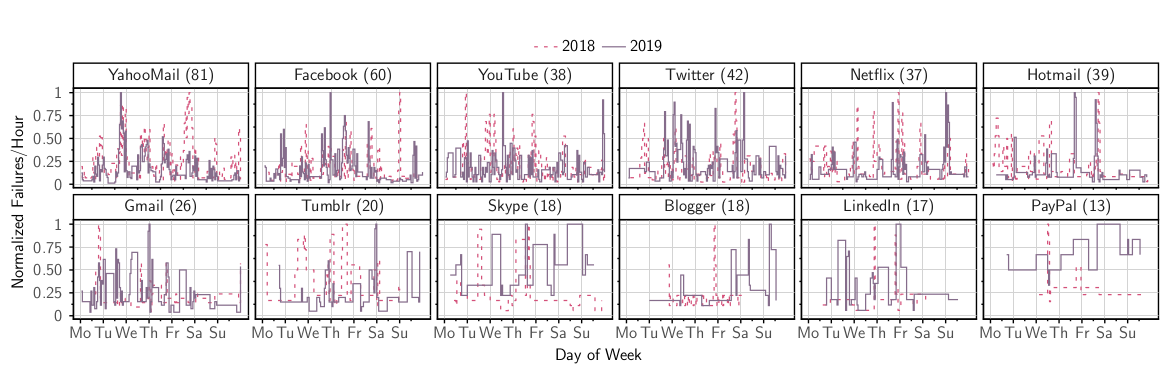

In [43]:
vendor_totals = weekly_trend_df.groupby('vendor_cat')['count'].max()

def label_func(vendor):
    return vendor + ' ({:,})'.format(vendor_totals.loc[vendor])

plt = ggplot(weekly_trend_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 3),
          legend_position='top',
          legend_key=element_rect(alpha=0),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_major_x=element_line(size=0.5, color='#D3D3D3'),
          panel_grid_major_y=element_line(size=0.5, color='#D3D3D3'),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          text=element_text(size=12),
          panel_border=element_rect(size=1)) +\
    geom_step(aes(x="hour_of_week", y="prop", color='year_cat', linetype='year_cat')) +\
    scale_color_manual(['#d45079', '#856c8b']) +\
    scale_linetype_manual([(0, (3, 5)), 'solid']) +\
    facet_wrap(facets='vendor_cat', nrow=2, labeller=label_func) +\
    scale_x_continuous(breaks = [0, 24, 48, 72, 96, 120, 144],
                    labels = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]) +\
    guides(color=guide_legend(title=''), linetype=guide_legend(title='')) +\
    xlab("Day of Week") +\
    ylab("Normalized Failures/Hour")

plt.save('figures/weekly_trend.pdf')
plt.draw()

In [44]:
year_trend_df_list = []
for year in all_intervals_df['year'].unique():
    for vendor in all_intervals_df['vendor'].unique():
        partial_df = all_intervals_df.loc[(all_intervals_df['year'] == year) & (all_intervals_df['vendor'] == vendor), :].copy()
        partial_df['week_of_year'] = partial_df['event_start_time'].dt.weekofyear
        
        partial_grouped_df = partial_df.groupby('week_of_year')['event_start_time'].count().reset_index()[['week_of_year', 'event_start_time']].rename(columns={'event_start_time': 'count'})
        partial_grouped_df['prop'] = partial_grouped_df['count'] / partial_grouped_df['count'].max()
        partial_grouped_df['vendor'] = vendor
        partial_grouped_df['year'] = year
    
        year_trend_df_list.append(partial_grouped_df)

year_trend_df = pd.concat(year_trend_df_list)
year_trend_df['vendor_cat'] = pd.Categorical(proper_vendor_names(year_trend_df['vendor']), descending_vendor_order, ordered=True)
year_trend_df['year_cat'] = year_trend_df['year'].replace([2018, 2019], ['2018', '2019'])

/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 4 in image.
  warn("Saving {0} x {1} {2} image.".format(
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/yearly_trend.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


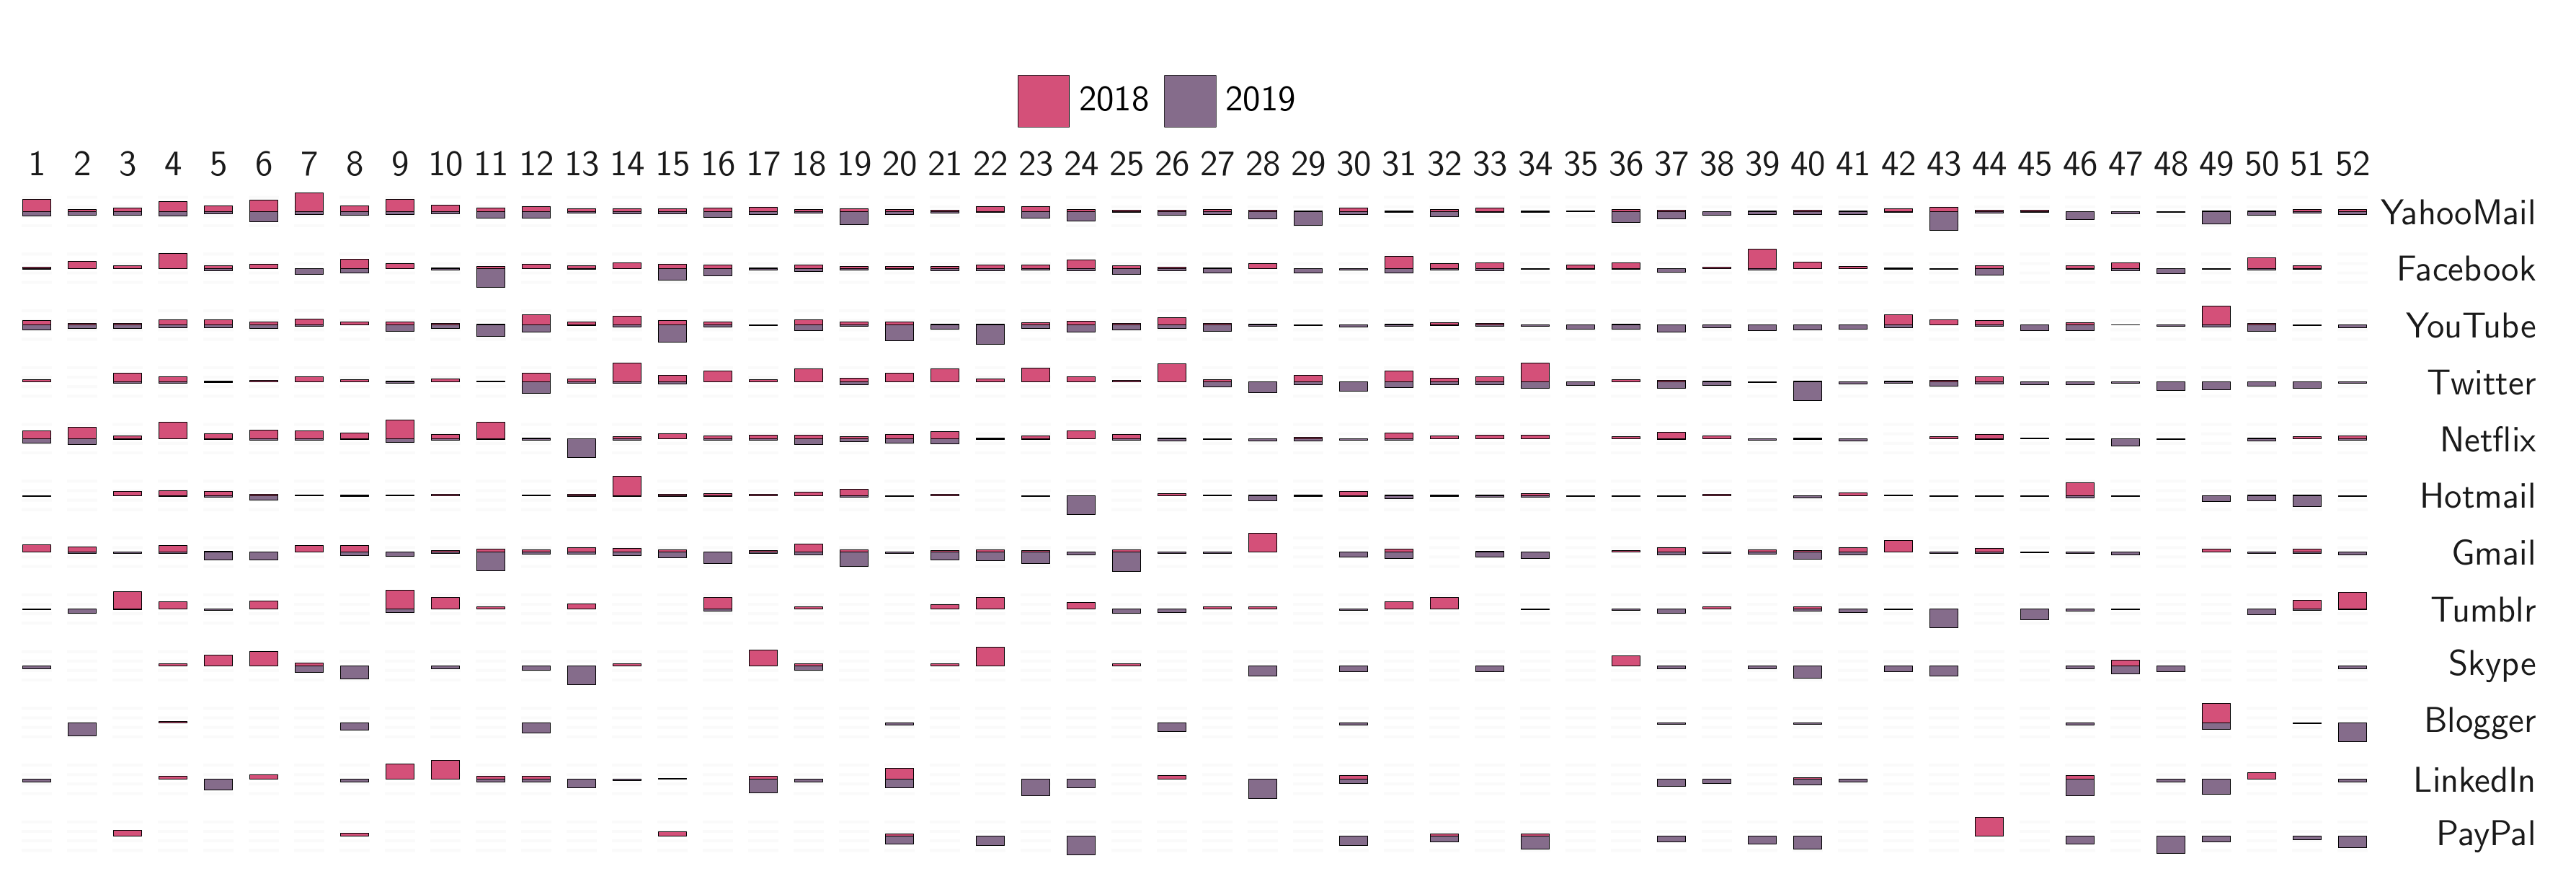

In [45]:
year_trend_df['hmm'] = 0

plt = ggplot(year_trend_df) +\
    theme_minimal(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 4), dpi=300,
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
         text=element_text(size=12),
         axis_text_x=element_blank(),
         axis_text_y=element_blank(),
         axis_ticks_major=element_blank(),
         panel_grid_major_x=element_line(size=0, color='#FFFFFF'),
         panel_grid_major_y=element_line(size=0, color='#FFFFFF'),
         strip_text_y=element_text(rotation=0, margin={'l': 50}, ha='right'),
         legend_position='top',
         axis_title_x=element_blank(),
         axis_title_y=element_blank()) +\
    geom_bar(aes(x='hmm', y='prop', fill='year_cat'), data=year_trend_df[year_trend_df['year'] == 2018], color='black', size=0.1, stat='sum') +\
    geom_bar(aes(x='hmm', y='-1 * prop', fill='year_cat'), data=year_trend_df[year_trend_df['year'] == 2019], color='black', size=0.1, stat='sum') +\
    facet_grid(['vendor_cat', 'week_of_year']) +\
    scale_fill_manual(['#d45079', '#856c8b']) +\
    scale_x_continuous(expand=(0.02, 0.02),
                       breaks=[5.42, 9.42, 13.85, 18.14, 22.57, 26.85, 31.28, 35.71, 39.71, 44.42, 48.71, 52.14],
                       labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) +\
    xlab("Week of Year") +\
    ylab("Cloud Service") +\
    guides(fill=guide_legend(title=''), color=None, shape=None, size=None)

plt.save('figures/yearly_trend.pdf')
plt.draw()

In [46]:
small_year_trend_df = year_trend_df.loc[(year_trend_df['vendor'] == 'yahoomail') | (year_trend_df['vendor'] == 'facebook') | (year_trend_df['vendor'] == 'youtube'), :].copy()
small_year_trend_df['vendor_cat'] = pd.Categorical(proper_vendor_names(small_year_trend_df['vendor']), descending_vendor_order, ordered=True)
small_year_trend_df['year_cat'] = small_year_trend_df['year'].replace([2018, 2019], ['2018', '2019'])

/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 1 in image.
  warn("Saving {0} x {1} {2} image.".format(
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/small_yearly_trend.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


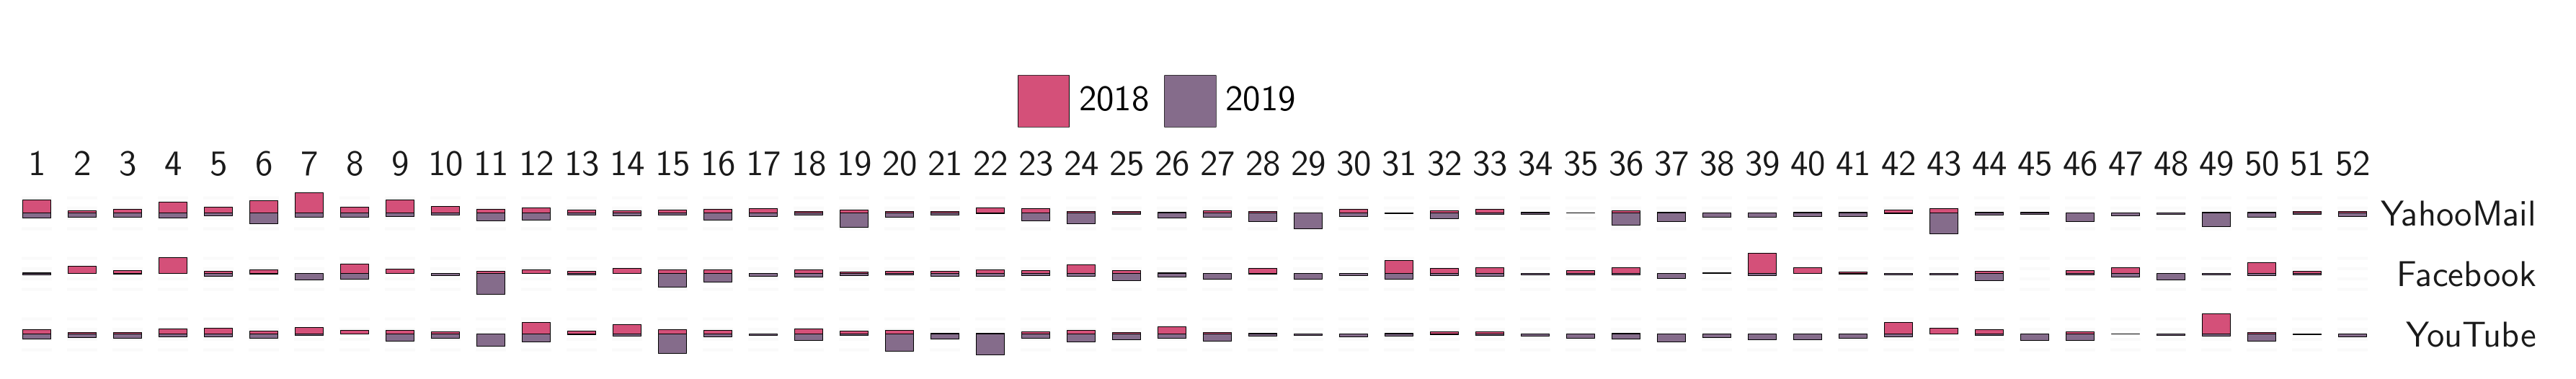

In [47]:
small_year_trend_df['hmm'] = 0

plt = ggplot(small_year_trend_df) +\
    theme_minimal(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 1), dpi=300,
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
         text=element_text(size=12),
         axis_text_x=element_blank(),
         axis_text_y=element_blank(),
         axis_ticks_major=element_blank(),
         panel_grid_major_x=element_line(size=0, color='#FFFFFF'),
         panel_grid_major_y=element_line(size=0, color='#FFFFFF'),
         strip_text_y=element_text(rotation=0, margin={'l': 50}, ha='right'),
         legend_position='top',
         axis_title_x=element_blank(),
         axis_title_y=element_blank()) +\
    geom_bar(aes(x='hmm', y='prop', fill='year_cat'), data=small_year_trend_df[small_year_trend_df['year'] == 2018], color='black', size=0.1, stat='sum') +\
    geom_bar(aes(x='hmm', y='-1 * prop', fill='year_cat'), data=small_year_trend_df[small_year_trend_df['year'] == 2019], color='black', size=0.1, stat='sum') +\
    facet_grid(['vendor_cat', 'week_of_year']) +\
    scale_fill_manual(['#d45079', '#856c8b']) +\
    scale_x_continuous(expand=(0.02, 0.02),
                       breaks=[5.42, 9.42, 13.85, 18.14, 22.57, 26.85, 31.28, 35.71, 39.71, 44.42, 48.71, 52.14],
                       labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) +\
    xlab("Week of Year") +\
    ylab("Cloud Service") +\
    guides(fill=guide_legend(title=''), color=None, shape=None, size=None)

plt.save('figures/small_yearly_trend.pdf')
plt.draw()

In [48]:
# Phew. Finally! Correlation
# 0 is down. 1 is up

def mark_event_active_hour(df):
    grid_array = np.full((365, 24), 0)
    for _, row in df.iterrows():
        start_day_of_year = row['event_start_time'].timetuple().tm_yday
        start_hour_of_day = row['event_start_time'].hour
        end_day_of_year = row['event_end_time'].timetuple().tm_yday
        end_hour_of_day = row['event_end_time'].hour
        for day_of_year in range(start_day_of_year, end_day_of_year+1):
            if start_day_of_year == end_day_of_year: # less than a day
                for hour_of_day in range(start_hour_of_day, end_hour_of_day+1):
                    grid_array[day_of_year-1, hour_of_day-1] = 1
            elif day_of_year == start_day_of_year: # first day
                for hour_of_day in range(start_hour_of_day, 24):
                    grid_array[day_of_year-1, hour_of_day-1] = 1
            elif day_of_year == end_day_of_year: # last day
                for hour_of_day in range(0, end_hour_of_day):
                    grid_array[day_of_year-1, hour_of_day-1] = 1
            else: # middle day
                for hour_of_day in range(1, 24):
                    grid_array[day_of_year-1, hour_of_day-1] = 1
    return grid_array.flatten()

def mark_event_start_hour(df):
    grid_array = np.full((365, 24), 0)
    for _, row in df.iterrows():
        day_of_year = row['event_start_time'].timetuple().tm_yday
        hour_of_day = row['event_start_time'].hour
        grid_array[day_of_year-1, hour_of_day-1] = 1
    return grid_array.flatten()

def mark_event_start_minute(df):
    grid_array = np.full((365, 24, 60), 0)
    for _, row in df.iterrows():
        day_of_year = row['event_start_time'].timetuple().tm_yday
        hour_of_day = row['event_start_time'].hour
        minute_of_hour = row['event_start_time'].minute
        grid_array[day_of_year-1, hour_of_day-1, minute_of_hour-1] = 1
    return grid_array.flatten()

def mark_event_start_quart(df):
    grid_array = np.full((365, 24, 4), 0)
    for _, row in df.iterrows():
        day_of_year = row['event_start_time'].timetuple().tm_yday
        hour_of_day = row['event_start_time'].hour
        quart_of_hour = np.ceil(row['event_start_time'].minute / 15).astype(np.int64)
        grid_array[day_of_year-1, hour_of_day-1, quart_of_hour-1] = 1
    return grid_array.flatten()

In [49]:
from statsmodels.tsa.stattools import acf

web_short_autocorrs = []
for vendor in all_intervals_df['vendor'].unique():
    partial_df = all_intervals_df[all_intervals_df['vendor'] == vendor]
    arr = mark_event_start_quart(partial_df)
    autocorrs = acf(arr, 2)
    web_short_autocorrs.append({
        'vendor': vendor,
        'lag 1': autocorrs[1],
        'lag 2': autocorrs[2]
    })
web_short_autocorrs_df = pd.DataFrame(web_short_autocorrs)
web_short_autocorrs_df

,vendor,lag 1,lag 2
0,youtube,0.350582,0.092888
1,netflix,0.378766,0.118566
2,yahoomail,0.414269,0.157263
3,facebook,0.432043,0.177332
4,gmail,0.395178,0.125159
5,twitter,0.395030,0.154155
6,hotmail,0.497159,0.286286
7,paypal,0.352008,0.057455
8,tumblr,0.513530,0.254493
9,linkedin,0.428381,0.147576


In [50]:
from scipy import stats
web_vendors = all_intervals_df['vendor'].unique()
web_correlations = []
for i in range(len(web_vendors)):
    for j in range(i+1, len(web_vendors)):
        vendor1 = web_vendors[i]
        vendor2 = web_vendors[j]
        
        arr1 = mark_event_start_minute(all_intervals_df[all_intervals_df['vendor'] == vendor1].copy().reset_index(drop=True))
        arr2 = mark_event_start_minute(all_intervals_df[all_intervals_df['vendor'] == vendor2].copy().reset_index(drop=True))
        
        (corr, pval) = stats.pearsonr(arr1, arr2)
        
        web_correlations.append({
            'vendor1': vendor1,
            'vendor2': vendor2,
            'corr': corr
        })

web_correlations_df = pd.DataFrame(web_correlations)
web_correlations_df.sort_values('corr')

,vendor1,vendor2,corr
36,facebook,skype,0.000309
33,facebook,paypal,0.001388
32,facebook,hotmail,0.003138
31,facebook,twitter,0.004065
35,facebook,linkedin,0.005420
...,...,...,...
40,gmail,paypal,0.074304
56,paypal,tumblr,0.074726
59,paypal,blogger,0.085814
57,paypal,linkedin,0.087588


In [51]:
# Medium term time dependence web
web_medium_autocorrs = []
for vendor in all_intervals_df['vendor'].unique():
    partial_df = all_intervals_df[all_intervals_df['vendor'] == vendor]
    arr = mark_event_start_quart(partial_df)
    autocorrs = acf(arr, 20)
    for i in range(1, 21):
        web_medium_autocorrs.append({
            'vendor': vendor,
            'lag': i / 4,
            'autocor': autocorrs[i]
        })
web_medium_autocorrs_df = pd.DataFrame(web_medium_autocorrs)

/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 3 in image.
  warn("Saving {0} x {1} {2} image.".format(
/var/scratch/stalluri/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/autocorrelation.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


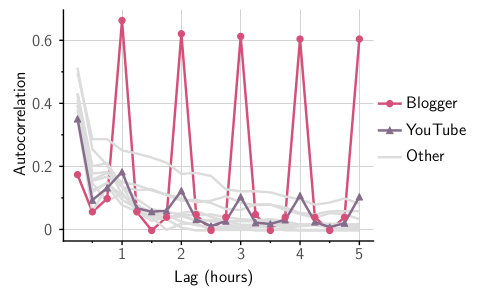

In [52]:
sorted_lag1 = web_medium_autocorrs_df[web_medium_autocorrs_df['lag'] == 1].sort_values('autocor', ascending=False).reset_index(drop=True)

web_medium_autocorrs_df['named'] = 'Other'

named_cat = []

# for i in range (3):
#     top_rank_vendor = sorted_lag1.loc[i, 'vendor']
#     web_medium_autocorrs_df.loc[web_medium_autocorrs_df['vendor'] == top_rank_vendor, 'named'] = top_rank_vendor.capitalize()
#     named_cat.append(top_rank_vendor.capitalize())

web_medium_autocorrs_df.loc[web_medium_autocorrs_df['vendor'] == 'blogger', 'named'] = 'Blogger'
web_medium_autocorrs_df.loc[web_medium_autocorrs_df['vendor'] == 'youtube', 'named'] = 'YouTube'


named_cat.append('Blogger')
named_cat.append('YouTube')
named_cat.append('Other')
    
web_medium_autocorrs_df['named'] = pd.Categorical(web_medium_autocorrs_df['named'], categories=named_cat)

plt = ggplot(web_medium_autocorrs_df) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    geom_line(aes(x='lag', y='autocor', group='vendor', color='named'), size=1) +\
    geom_point(aes(x='lag', y='autocor', group='vendor', color='named', shape='named'), size=2) +\
    theme(legend_title=element_text(size=0, alpha=0),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_text=element_text(size=12),
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          figure_size=(4, 3),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_major_x=element_line(size=0.5, color='#D3D3D3'),
          panel_grid_major_y=element_line(size=0.5, color='#D3D3D3'),
          text=element_text(size=12)) +\
    guides(color=guide_legend(ncol=1)) +\
    scale_color_manual(['#d45079', '#856c8b', 'gainsboro']) +\
    scale_shape_manual(['o', '^', '']) +\
    xlab('Lag (hours)') +\
    ylab('Autocorrelation')

plt.save('figures/autocorrelation.pdf')
plt.draw()